In [3]:
import os
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
# Caminhos para imagens e máscaras
IMAGE_DIR = 'database/VOC2012_train_val/VOC2012_train_val/JPEGImages/'
MASK_DIR = 'database/VOC2012_train_val/VOC2012_train_val/SegmentationClass/'

IMG_SIZE = (128, 128)  # Redimensionamento das imagens
NUM_CLASSES = 3  # Pascal VOC tem 21 classes (20 + 1 fundo)
datasset, info = tfds.load('oxford_iiit_pet', with_info=True)
def process_mask(mask):
    """Ajusta os valores da máscara para a faixa permitida e aplica one-hot encoding."""
    return np.clip(mask, 0, NUM_CLASSES - 1)  # Garantir que os valores estejam no intervalo [0, 20]

def load_image_mask(sample):
    """Carrega uma imagem e sua máscara correspondente."""
    img = tf.image.resize(sample['image'], (128, 128))
    mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    #Augmetation
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Converter para arrays NumPy
    img = tf.cast(img, tf.float32) / 255.0  # Normalizar imagem para [0, 1]
    mask = mask - 1

    return img, mask

def load_dataset(datasset):
    """Carrega todas as imagens e máscaras do diretório."""
    datasset_treino = datasset['train'].map(load_image_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    datasset_teste = datasset['test'].map(load_image_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return datasset_treino, datasset_teste

# Carregar as imagens e máscaras

BATCH_SIZE = 64
BUFFER_SIZE = 1000

datasset_treino, datasset_teste = load_dataset(datasset)
datasset_treino = datasset_treino.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
datasset_treino = datasset_treino.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
datasset_teste = datasset_teste.batch(BATCH_SIZE)


def plot_and_save(history, metric, save_path):
    """Gera e salva um gráfico da métrica fornecida."""
    plt.figure()

    # Plotar os dados de treino e validação
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')

    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    # Salvar o gráfico
    plt.savefig(save_path)
    plt.close()  # Fechar para liberar memória



# Definir o modelo U-Net para segmentação semântica


def conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample(x, n_filters):
    f = conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = conv_block(x, n_filters)
    return x

def unet_model(input_size=(128, 128, 3), num_classes=21):
     # input layer
    inputs = tf.keras.layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample(inputs, 64)
    f2, p2 = downsample(p1, 128)
    f3, p3 = downsample(p2, 256)
    f4, p4 = downsample(p3, 512)

    # intermediate block
    intermediate_block = conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample(intermediate_block, f4, 512)
    u7 = upsample(u6, f3, 256)
    u8 = upsample(u7, f2, 128)
    u9 = upsample(u8, f1, 64)

    # output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(u9)

    # unet model
    model = tf.keras.Model(inputs, outputs, name='U-Net')
    return model


# Compilar o modelo
model = unet_model(num_classes=3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinamento
epocas = 20
passos_epoca = info.splits['train'].num_examples // BATCH_SIZE
passos_validacao = info.splits['test'].num_examples // BATCH_SIZE
history = model.fit(datasset_treino, epochs=epocas, steps_per_epoch=passos_epoca, validation_steps=passos_validacao, validation_data=datasset_teste)
# Gerar e salvar os gráficos de Loss e Accuracy
plot_and_save(history, 'loss', 'loss_plot.png')
plot_and_save(history, 'accuracy', 'accuracy_plot.png')
model.save('unet_model.h5')


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5224 - loss: 4.5079 - val_accuracy: 0.6636 - val_loss: 0.7971
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6526 - loss: 0.7973 - val_accuracy: 0.7149 - val_loss: 0.6970
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7151 - loss: 0.6812 - val_accuracy: 0.7329 - val_loss: 0.6409
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 825ms/step - accuracy: 0.7348 - loss: 0.6313 - val_accuracy: 0.7509 - val_loss: 0.5866
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7409 - loss: 0.6229 - val_accuracy: 0.7513 - val_loss: 0.5883
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 824ms/step - accuracy: 0.7590 - loss: 0.5751 - val_accuracy: 0.7649 - val_loss: 0.5637
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7763 - loss: 0.5360 - val_accuracy: 0.7545 - val_loss: 0.6725
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7971 - loss: 0.4939 - val_accuracy: 0.8142 - val_loss: 0.4533
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8094 - loss: 0.4659 - val_accuracy: 0.7854 - val_loss: 0.5572
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 822ms/step - accuracy: 0.8167 - loss: 0.4496 - val_accuracy: 0.8184 - val_loss: 

In [8]:
def plot_amostra(image_list):
    plt.figure(figsize=(10,10))
    title = ['Imagem de Entrada', 'Verdadeira Mascara', 'Mascara Predita']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

def criar_mascara(predicao_mask):
    predicao_mask = tf.argmax(predicao_mask, axis=-1)
    predicao_mask = predicao_mask[..., tf.newaxis]
    return predicao_mask[0]

def pegar_predicoes(model, datasset=None, num=1):
    if datasset:
        for img, mask in datasset.take(num):
            predict_mask = model.predict(img)
            plot_amostra([img[0], mask[0], criar_mascara(predict_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step


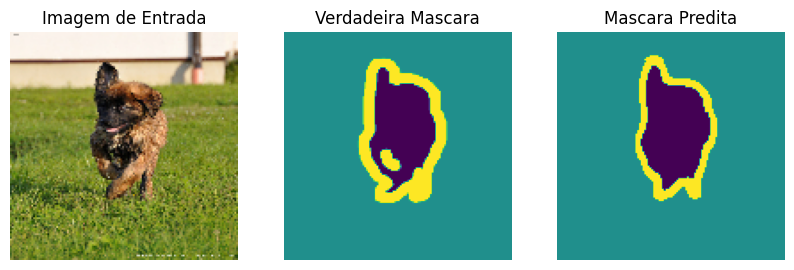

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


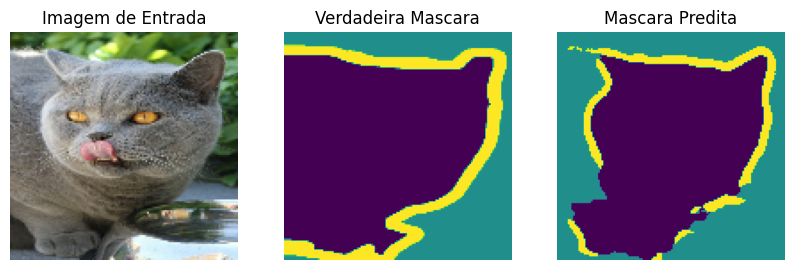

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


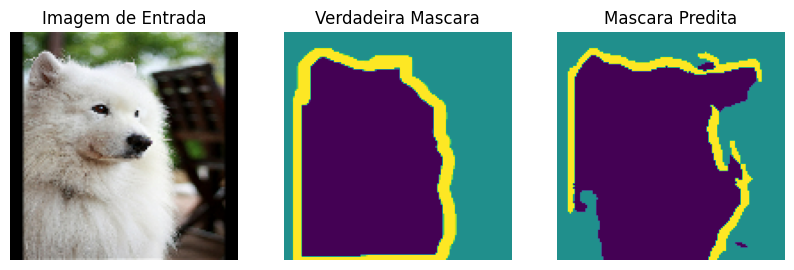

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


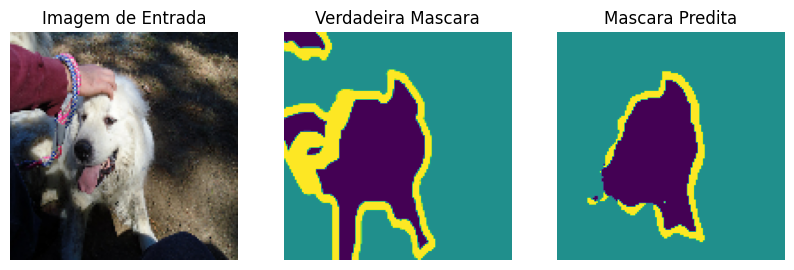

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


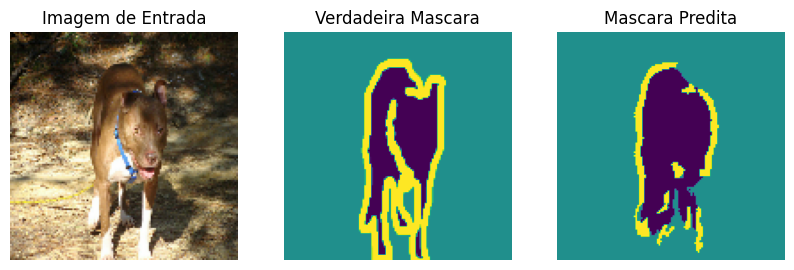

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


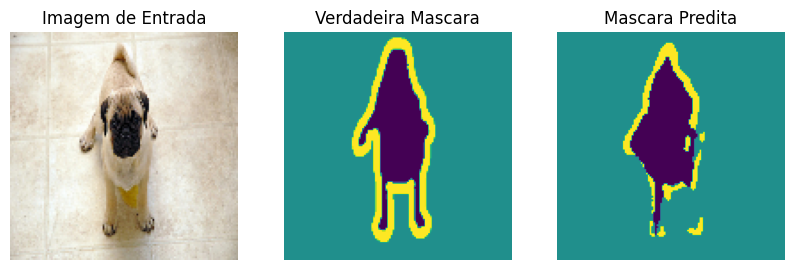

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


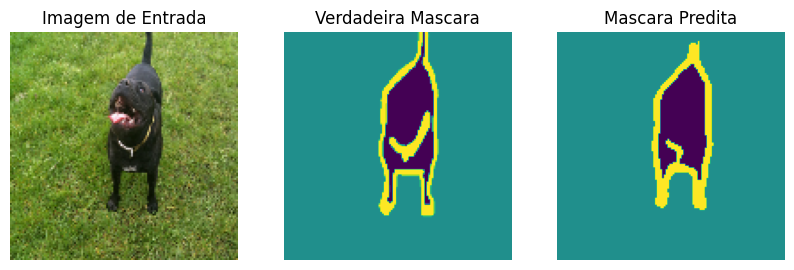

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


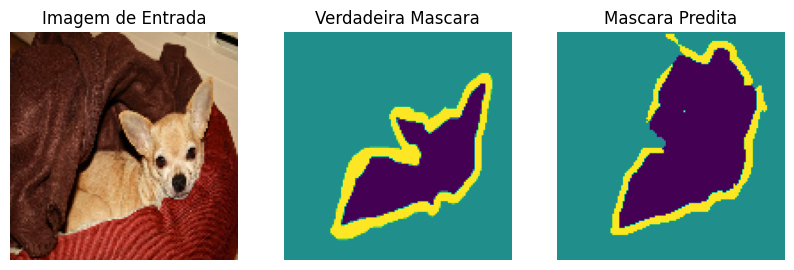

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


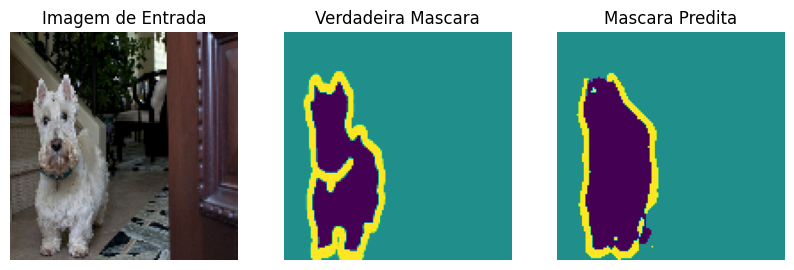

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


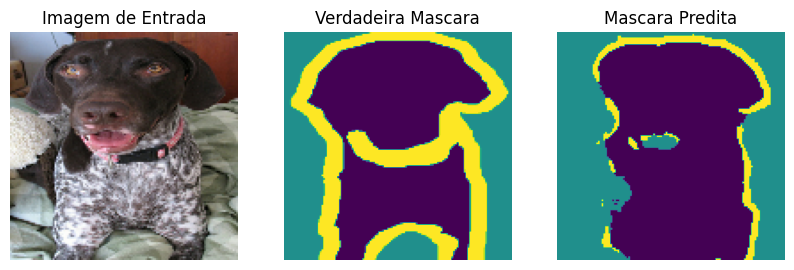

In [9]:
from tensorflow.keras.models import load_model
modelo = load_model('unet_model.h5')
pegar_predicoes(modelo, datasset_teste, 10)